# Advanced Lane Finding
In the following, the individual steps of my lane finding pipeline are listed. In my README, I explain the overall workflow. This jupyter notebook will provide comments on the individual code snippets

In [1]:
# Begin by loading some examples similar to what was done in the first lane detection project
# Import the necessary libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import glob

%matplotlib inline
testfiles = glob.glob("test_images/*")

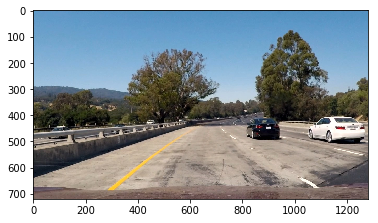

In [2]:
# Show one of the images from the test images
test_image = mpimg.imread(testfiles[1])
plt.imshow(test_image)

 I had trouble remembering if mpimg converts to RGB or BGR. I'm leaning towards the RGB case, but let's do a test
 Below I show the first channel which according to my hypothesis is the red channel.
 Since this channel is decoupled from the blue channel, it should give a really low value for the top of the image
 (shown previously, above)

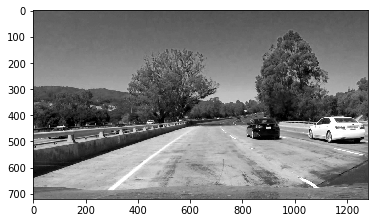

In [3]:
plt.imshow(test_image[:,:,0], cmap="gray")

Indeed, the top of the image has a lower value (the pixels are darker). This means that channel 0 is the red channel and that the mpimg imports to the RGB format

## Camera Calibration

In [4]:
# Similarly, prepare and load the calibration images for the camera calibration
calibrationfiles = glob.glob("camera_cal/*")

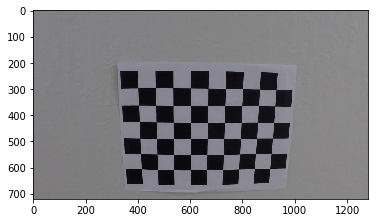

In [5]:
# Show one of the images from the calibration images
calibration_image = mpimg.imread(calibrationfiles[1])
plt.imshow(calibration_image)

In [6]:
# Prepare for camera calibration
# Write up some helper functions

def toGray(image):
    return cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

def getCorners(image):
    # For the purpose of this project, the calibration images have a fixed grid size of 9X6
    ret, corners = cv2.findChessboardCorners(image, (9, 6), None)
    if ret:
        return corners

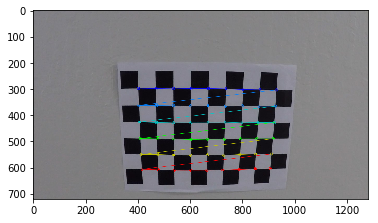

In [7]:
# Show an example processing output
corners = getCorners(toGray(calibration_image))
drawn_corners_image = cv2.drawChessboardCorners(calibration_image, (9,6), corners, True)
plt.imshow(drawn_corners_image)

So far so good!

In [8]:
# Bring up numpy so we can carry out some matrix calculations
import numpy as np

In [9]:
# Create more helper functions for getting the calibration parameters

def getDistortionParams():
    # define container for object points
    obj_points    = []
    corner_points = []
    img_shape     = (-1,-1)
    
    grid_points = np.zeros((6*9,3), np.float32)
    grid_points[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    for file in calibrationfiles:
        image = mpimg.imread(file)
        corners = getCorners(toGray(image))
        if corners is not None:
            corner_points.append(corners)
            obj_points.append(grid_points)
            img_shape = (image.shape)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, corner_points, img_shape[0:2], None, None)
    return ret, mtx, dist, rvecs, tvecs

In [10]:
# Obtain the distortion parameters
ret, mtx, dist, rvecs, tvecs = getDistortionParams()

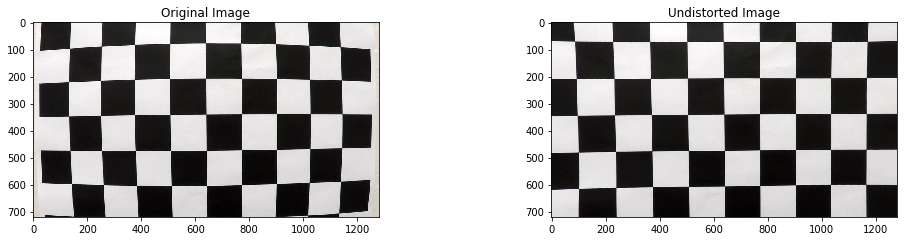

In [11]:
# Show an example undistortion
calibration_image = mpimg.imread(calibrationfiles[0])
undist = cv2.undistort(calibration_image, mtx, dist)

plt.subplot(1,2,1)
plt.imshow(calibration_image)
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(undist)
plt.title("Undistorted Image")
plt.subplots_adjust(left=0., right=2, top=1, bottom=0., wspace=0.5)

Still looks good

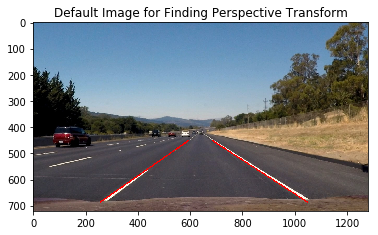

In [12]:
# Prepare for perspective transform
# Load straight lines image
straight_line_image = mpimg.imread("test_images/straight_lines2.jpg")
lanes = cv2.line(straight_line_image.copy(), (256,686), (594, 451), [255,0,0], 3 )
cv2.line(lanes, (1049,686), (685, 451), [255,0,0], 3 )

plt.imshow(lanes)
plt.title("Default Image for Finding Perspective Transform")

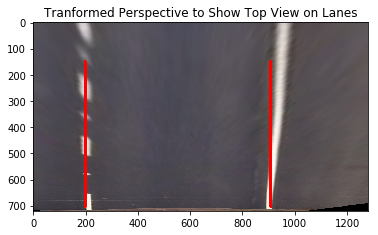

In [13]:
# Perform perspective transform and visualize
src_points = np.float32([ [299, 652], [594, 451], [1008, 652], [685, 451] ])
dest_points= np.float32([ [199, 702], [199, 150  ], [908, 702], [908 , 150 ] ])
M = cv2.getPerspectiveTransform(src_points, dest_points)    
Minv = cv2.getPerspectiveTransform(dest_points, src_points)    
und = cv2.undistort(straight_line_image, mtx, dist)
warped = cv2.warpPerspective(und, M, (straight_line_image.shape[1], straight_line_image.shape[0]), flags=cv2.INTER_LINEAR) 
cv2.line(warped, (199, 702), (199, 150), [255,0,0], 10 )
cv2.line(warped, (908, 702),  (908 , 150), [255,0,0], 10 )
plt.imshow(warped)
plt.title("Tranformed Perspective to Show Top View on Lanes")

##  Filtering Techniques

In [14]:
# Prepare color filtering techniques
def s_select(img, thresh=(60, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    S = hls[:,:,2]
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(S).astype(np.uint8)
    binary_output[(S <= thresh[1]) & (S > thresh[0])] = 1
    return binary_output

def v_select(img, thresh=(200, 255)):
    # 1) Convert to hsv color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # 2) Apply a threshold to the S channel
    H = hsv[:,:,2]
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(H).astype(np.uint8)
    binary_output[(H <= thresh[1]) & (H > thresh[0])] = 1
    return binary_output

def yellow_select(img):
    return h_select(thresh=(20, 30))

def h_select(img, thresh=(20, 30)):
    # 1) Convert to hsv color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # 2) Apply a threshold to the S channel
    H = hsv[:,:,0]
    s_mask = s_select(img,(30,255))
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(H).astype(np.uint8)
#     binary_output[(H <= thresh[1]) & (H > thresh[0]) & (s_mask == 1) ] = 1
    binary_output[(H <= thresh[1]) & (H > thresh[0]) ] = 1

    return binary_output

def dir_threshold(img, sobel_kernel=5, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(grad_dir)
    # 5) Create a binary mask where mag thresholds are met
    binary_output[(grad_dir > thresh[0]) & (grad_dir < thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    return grad_binary

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_mag = np.sqrt(sobely**2 + sobelx**2)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(grad_mag)
    # 5) Create a binary mask where mag thresholds are met
    binary_output[(grad_mag > thresh[0]) & (grad_mag < thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def gray_select(img, thresh=(0, 255)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    binary_output = np.zeros_like(img)
    # 5) Create a binary mask where mag thresholds are met
    binary_output[(img > thresh[0]) & (img < thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

The image used for lane detection is the union of a gradient direction and magnitude based filter and a saturation and hue based filter.

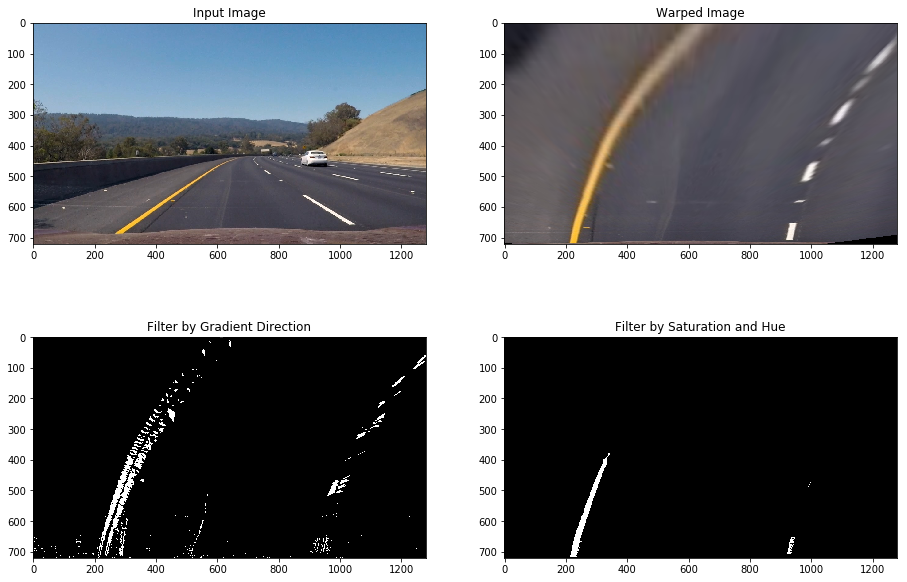

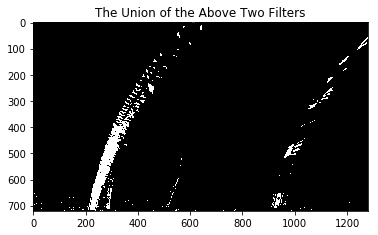

In [15]:
# Visualizing the filtering techniques
image = mpimg.imread("test_images/test3.jpg")
full_image = mpimg.imread("test_images/test5.jpg")
image = cv2.resize(image,(full_image.shape[1],full_image.shape[0]))

# output = line.process_image(image)
# plt.imshow(output)

undistorted = cv2.undistort(image, mtx, dist)
warped = cv2.warpPerspective(undistorted, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)     

equalized = cv2.equalizeHist(cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)[:,:,2])
plt.figure()
plt.imshow(equalized, cmap="gray")

ksize = 3
mag_binary = mag_thresh(warped, sobel_kernel=ksize, thresh=(15, 150))
dir_binary = dir_threshold(warped, sobel_kernel=9, thresh=(.0, .5))
s_binary = s_select(warped, thresh=(150, 255))
g_binary = gray_select(warped, thresh=(150,255))
h_binary = (h_select(warped, thresh=(15, 35)) == 1) | (h_select(warped, thresh=(0, 20)) == 1)

dir_filter = np.zeros_like(dir_binary)
dir_filter[((mag_binary == 1) & (dir_binary == 1))] = 1
sat_filter = np.zeros_like(dir_binary)
sat_filter[(h_binary == 1) &  (s_binary == 1)] = 1

combined = np.zeros_like(dir_binary)
combined[ (dir_binary == 1) & (mag_binary == 1) | (h_binary == 1) &  (s_binary == 1) ] = 1

plt.subplot(2,2,1)
plt.imshow(image)
plt.title("Input Image")
plt.subplot(2,2,2)
plt.imshow(warped)
plt.title("Warped Image")
plt.subplot(2,2,3)
plt.imshow(dir_filter, cmap="gray")
plt.title("Filter by Gradient Direction")
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=None, hspace=None)
plt.subplot(2,2,4)
plt.imshow(sat_filter, cmap="gray")
plt.title("Filter by Saturation and Hue")
plt.figure()
plt.imshow(combined, cmap="gray")
plt.title("The Union of the Above Two Filters")

## Further Conversions

In what follows, the conversion from pixel space (in the warped image) to world space for the lane curvation and deviation from track center will be covered.

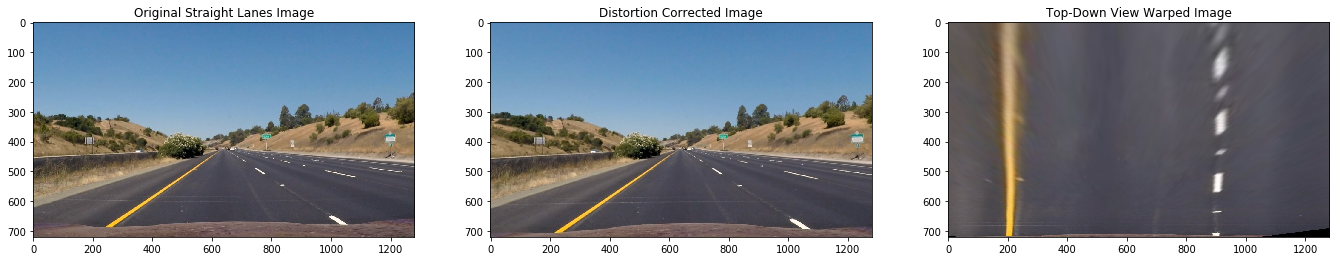

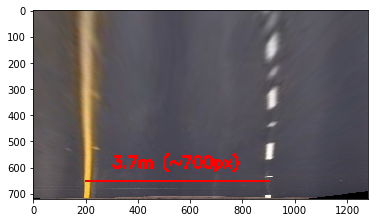

In [16]:
# Show the distortion corrected image
image = mpimg.imread("test_images/straight_lines1.jpg")
undistorted = cv2.undistort(image, mtx, dist)
warped = cv2.warpPerspective(undistorted, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)     

plt.subplot(1,3,1)
plt.imshow(image)
plt.title("Original Straight Lanes Image")
plt.subplot(1,3,2)
plt.imshow(undistorted)
plt.title("Distortion Corrected Image")
plt.subplot(1,3,3)
plt.imshow(warped)
plt.title("Top-Down View Warped Image")
plt.subplots_adjust(left = 0, right = 3)

cv2.putText(warped,"3.7m (~700px)", (300,600), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 10 )
cv2.line(warped, (200, 650), (900, 650), 255 , 5)
plt.figure()
plt.imshow(warped)

In [17]:
# Prepare to work on video
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Below a line detection class is instantiated to help with storing information over several frames. 
Specifically, an averaging window of width 15 image frames is applied to smoothen the behavior of the 
lane detection-tracker

In [19]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.left_ma_best_fit = None  
        self.right_ma_best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # has the line been initialized?
        self.rightx_base = None
        self.leftx_base = None
        
        self.iter = 0
        self.left_list = list()
        self.left_params_total = 0
        self.right_list = list()
        self.right_params_total = 0
        self.ma_filter_length = 15
        
    def process_image(self, image):
        
        self.iter += 1
        
        undistorted = cv2.undistort(image, mtx, dist)
        warped = cv2.warpPerspective(undistorted, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR) 

        binary_warped = s_select(warped, thresh=(150, 255))

        ksize = 3
        mag_binary = mag_thresh(warped, sobel_kernel=ksize, thresh=(15, 150))
        dir_binary = dir_threshold(warped, sobel_kernel=9, thresh=(.0, .5))
        s_binary = s_select(warped, thresh=(150, 255))
        h_binary = (h_select(warped, thresh=(15, 35)) == 1) | (h_select(warped, thresh=(0, 20)) == 1)

        combined = np.zeros_like(binary_warped)
        combined[ (dir_binary == 1) & (mag_binary == 1) | (h_binary == 1) & (s_binary == 1) ] = 1    

        binary_warped = combined
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
        leftx_base  = None
        rightx_base = None
        
        if self.detected == False:
            histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]/2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint
            self.leftx_base = leftx_base
            self.rightx_base = rightx_base
            self.detected = True
        else:
            leftx_base  = self.leftx_base
            rightx_base = self.rightx_base

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 150
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        ym_per_pix = 30/720
        xm_per_pix = 3.7/700
        y_eval = image.shape[0]
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
        right_fit = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
        
        if len(self.left_list) < self.ma_filter_length:
            self.left_list.append(left_fit)
            self.left_params_total += left_fit
            self.right_list.append(right_fit)
            self.right_params_total += right_fit
        else:
            # Use the moving window best fits
            self.left_list.append(left_fit)
            self.left_params_total += left_fit
            self.left_params_total -= self.left_list[0]
            self.left_list.pop(0)
            
            self.right_list.append(right_fit)
            self.right_params_total += right_fit
            self.right_params_total -= self.right_list[0]
            self.right_list.pop(0)
            left_fit  = self.left_params_total / self.ma_filter_length   
            right_fit = self.right_params_total / self.ma_filter_length
        
        # Evaluate the slope at the bottom of the image
        average_fit = ( left_fit + right_fit ) * 0.5
        average_curvature = ((1 + (2*average_fit[0]*y_eval*ym_per_pix + average_fit[1])**2)**1.5) / np.absolute(2*average_fit[0])
        
        # Considering the positive axis to point to the right of the image, the deviation from center line
        # is given by the offset of the right lane minus the offset of the left lane
        center_line_x = (right_fit[0]*(y_eval*ym_per_pix)**2 + right_fit[1]*y_eval*ym_per_pix + right_fit[2] + left_fit[0]*(ym_per_pix*y_eval)**2 + left_fit[1]*y_eval*ym_per_pix + left_fit[2]) * 0.5
        deviation_from_center = 560 * xm_per_pix - center_line_x  

        
        # Fit a second order polynomial in pixel space to display
        left_fit = np.polyfit(lefty , leftx , 2)
        right_fit = np.polyfit(righty , rightx , 2)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Create an image to draw the lines on
        color_warp = np.zeros_like(image)    
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        # Highlight polynomial support points
        color_warp[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        color_warp[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]  
        
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255] 
        
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))       
        # Combine the result with the original image
        result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
        
        # add information about the curvature and deviation from center
        curvature_text = "Curvature Radius(m): " + "{:.1f}".format(average_curvature)
        cv2.putText(result, curvature_text, (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, [255,255,255,120], 3 )
        deviation_text = "Right of Center(m): " + "{:.1f}".format(deviation_from_center)
        cv2.putText(result, deviation_text, (50,160), cv2.FONT_HERSHEY_SIMPLEX, 1, [255,255,255,120], 3 )

        
        debug_img = cv2.hconcat( (combined * 255, s_binary * h_binary * 255  ) )
        debug_img = np.dstack( (debug_img, debug_img, debug_img) )                        
        
        return out_img

In [20]:
# Create lane detector instance
line = Line()

In [182]:
# Create lane detector instance
line = Line()
# Process base case
base_output = 'base_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(line.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(base_output, audio=False)

[MoviePy] >>>> Building video base_output.mp4
[MoviePy] Writing video base_output.mp4


100%|█████████▉| 1260/1261 [04:57<00:00,  4.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: base_output.mp4 

CPU times: user 10min 53s, sys: 2.33 s, total: 10min 55s
Wall time: 4min 58s


In [183]:
# Show base case results
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(base_output))

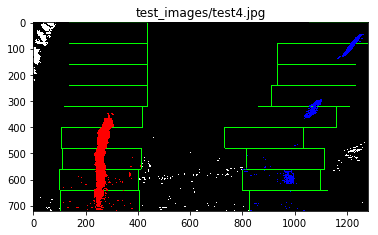

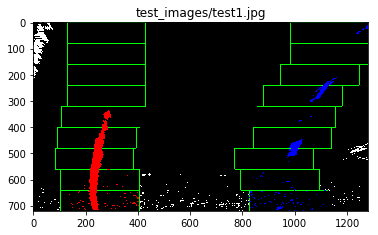

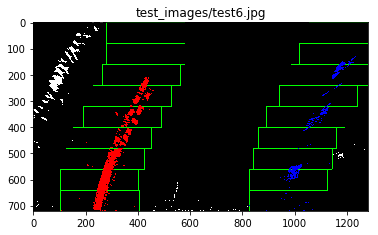

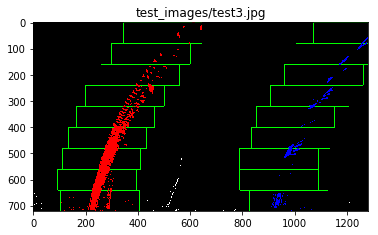

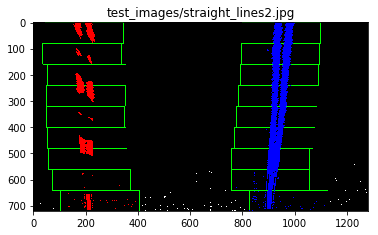

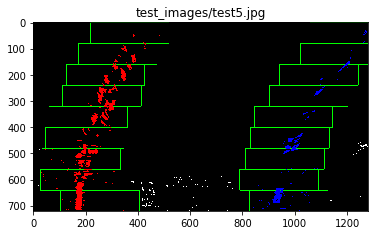

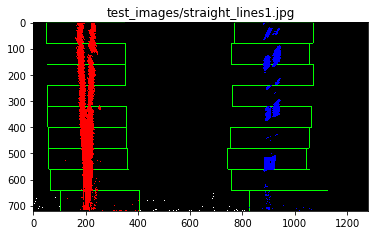

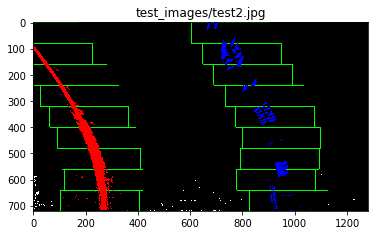

In [21]:
for file in testfiles:
    output = line.process_image(mpimg.imread(file))
    plt.imshow(output)
    plt.title(file)
    plt.figure()